Running Simulated Annealing for TSP...
Best distance found: 352.32
Visualizing algorithm progression...


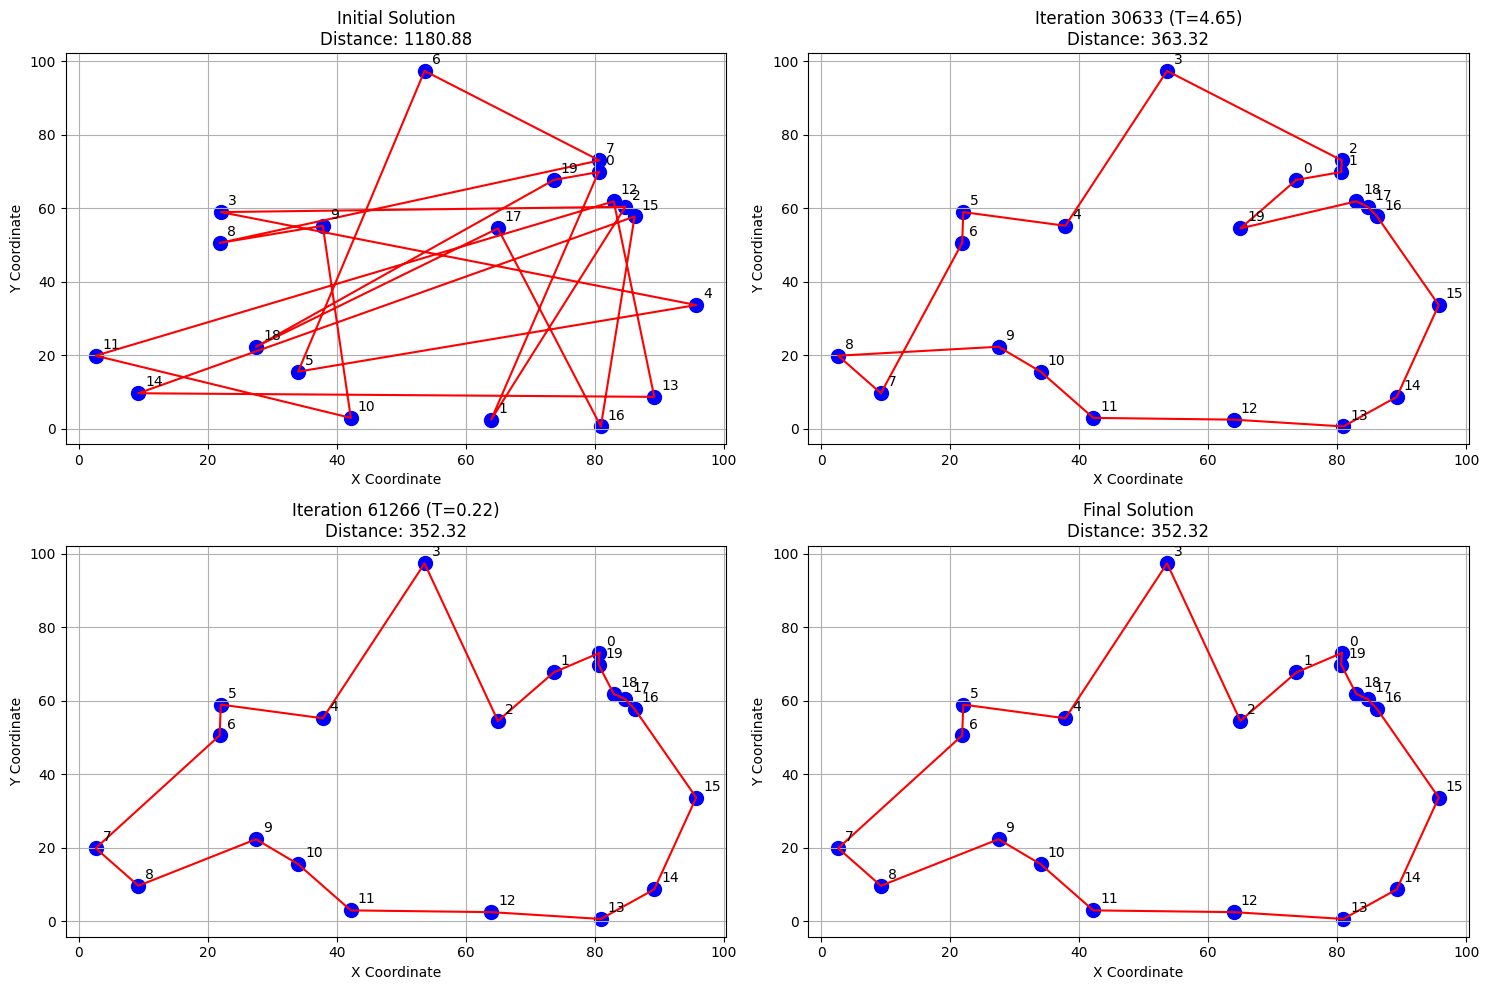

Visualizing final solution...


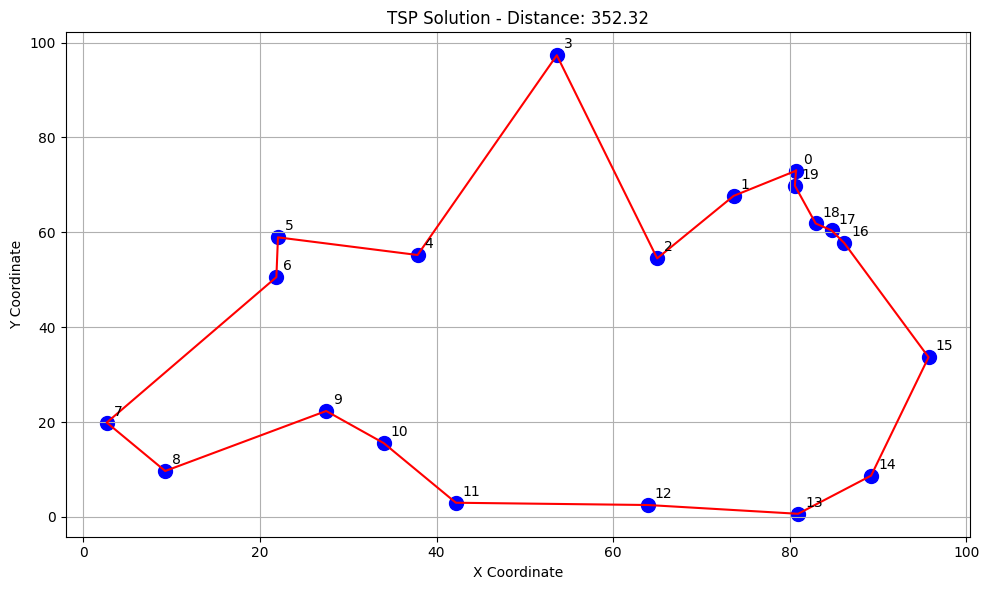

Visualizing convergence...


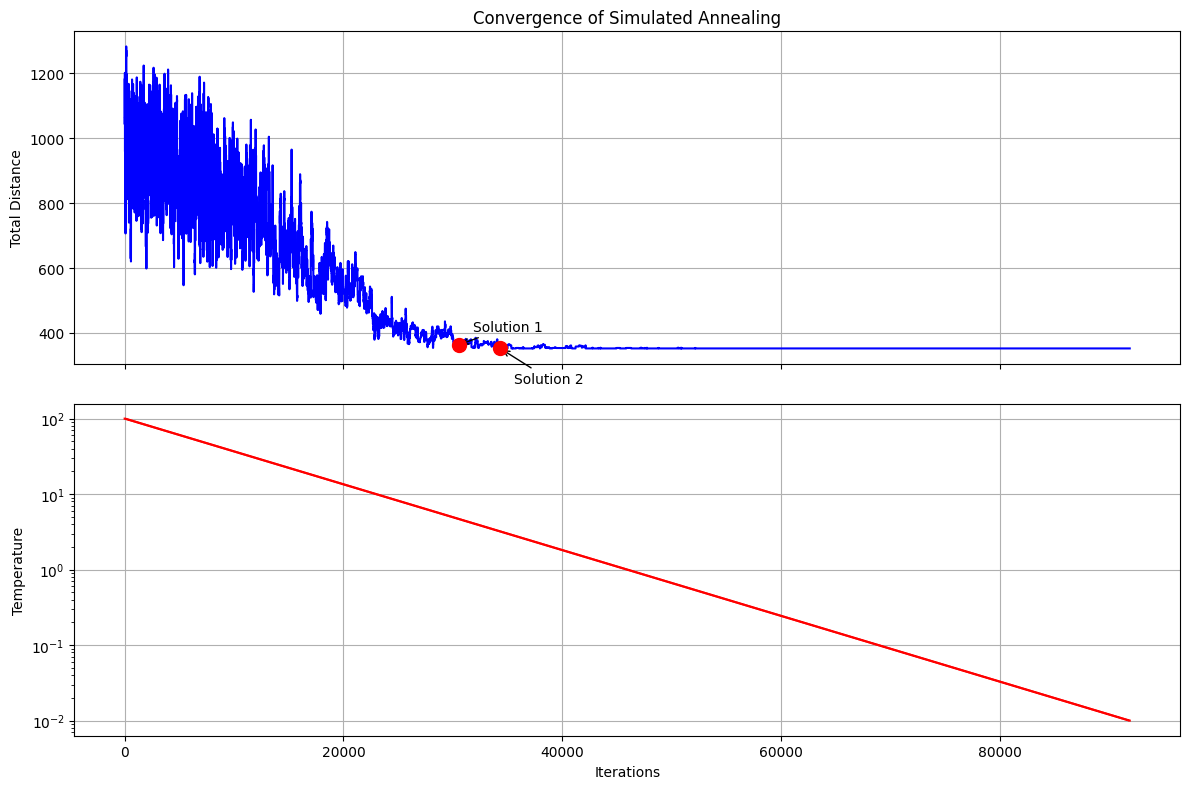

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from typing import List, Tuple, Callable

def simulated_annealing(
    objective_function: Callable,
    initial_solution: List,
    neighbor_generator: Callable,
    initial_temperature: float = 100.0,
    cooling_rate: float = 0.95,
    min_temperature: float = 0.01,
    iterations_per_temp: int = 100,
    save_intermediate_solutions: bool = True,
    num_intermediate_solutions: int = 2
) -> Tuple[List, float, List, List, List]:
    """
    Generic simulated annealing algorithm with intermediate solution tracking.

    Args:
        objective_function: Function to minimize
        initial_solution: Starting solution
        neighbor_generator: Function to generate neighboring solution
        initial_temperature: Starting temperature
        cooling_rate: Factor to reduce temperature (between 0 and 1)
        min_temperature: Stopping temperature
        iterations_per_temp: Iterations at each temperature level
        save_intermediate_solutions: Whether to save intermediate solutions
        num_intermediate_solutions: Number of intermediate solutions to save

    Returns:
        best_solution, best_cost, cost_history, temperature_history, intermediate_solutions
    """
    current_solution = initial_solution.copy()
    current_cost = objective_function(current_solution)

    best_solution = current_solution.copy()
    best_cost = current_cost

    temperature = initial_temperature
    cost_history = [current_cost]
    temperature_history = [temperature]

    # Track intermediate solutions at different stages
    intermediate_solutions = []
    if save_intermediate_solutions:
        intermediate_solutions.append((
            initial_solution.copy(),
            current_cost,
            temperature,
            "Initial Solution"
        ))

    # Calculate at roughly what iterations we want to save intermediate solutions
    total_iterations = 0
    temp = temperature
    while temp > min_temperature:
        total_iterations += iterations_per_temp
        temp *= cooling_rate

    save_points = [int(total_iterations * i / (num_intermediate_solutions + 1))
                  for i in range(1, num_intermediate_solutions + 1)]

    iteration_count = 0

    while temperature > min_temperature:
        for _ in range(iterations_per_temp):
            iteration_count += 1

            # Generate a neighboring solution
            new_solution = neighbor_generator(current_solution)

            # Calculate the new cost
            new_cost = objective_function(new_solution)

            # Calculate the cost difference
            cost_diff = new_cost - current_cost

            # Accept the new solution based on acceptance probability
            if cost_diff <= 0:  # Better solution (lower cost)
                current_solution = new_solution
                current_cost = new_cost

                # Update best solution if needed
                if new_cost < best_cost:
                    best_solution = new_solution.copy()
                    best_cost = new_cost
            else:  # Worse solution
                # Accept with probability e^(-cost_diff/temperature)
                acceptance_probability = math.exp(-cost_diff / temperature)
                if random.random() < acceptance_probability:
                    current_solution = new_solution
                    current_cost = new_cost

            cost_history.append(current_cost)
            temperature_history.append(temperature)

            # Check if we should save an intermediate solution
            if save_intermediate_solutions and iteration_count in save_points:
                intermediate_solutions.append((
                    current_solution.copy(),
                    current_cost,
                    temperature,
                    f"Iteration {iteration_count} (T={temperature:.2f})"
                ))

        # Cool down
        temperature *= cooling_rate

    # Add the final best solution
    if save_intermediate_solutions:
        intermediate_solutions.append((
            best_solution.copy(),
            best_cost,
            0,
            "Final Solution"
        ))

    return best_solution, best_cost, cost_history, temperature_history, intermediate_solutions


# Example: Solving Traveling Salesman Problem with Simulated Annealing

def generate_random_cities(num_cities: int, max_coord: int = 100) -> List[Tuple[float, float]]:
    """Generate random city coordinates"""
    return [(random.uniform(0, max_coord), random.uniform(0, max_coord))
            for _ in range(num_cities)]

def calculate_distance(city1: Tuple[float, float], city2: Tuple[float, float]) -> float:
    """Calculate Euclidean distance between two cities"""
    return math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

def total_distance(tour: List[int], cities: List[Tuple[float, float]]) -> float:
    """Calculate total tour distance"""
    distance = 0
    for i in range(len(tour)):
        distance += calculate_distance(cities[tour[i]], cities[tour[(i + 1) % len(tour)]])
    return distance

def swap_cities(tour: List[int]) -> List[int]:
    """Generate a neighboring solution by swapping two cities"""
    new_tour = tour.copy()
    i, j = random.sample(range(len(tour)), 2)
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def visualize_solution(tour: List[int], cities: List[Tuple[float, float]], title: str):
    """Visualize the TSP solution"""
    plt.figure(figsize=(10, 6))

    # Plot cities
    xs, ys = zip(*[cities[i] for i in tour])
    plt.scatter(xs, ys, c='blue', s=100)

    # Plot tour path
    tour_with_return = tour + [tour[0]]  # Return to the starting city
    xs, ys = zip(*[cities[i] for i in tour_with_return])
    plt.plot(xs, ys, 'r-')

    # Add city labels
    for i, (x, y) in enumerate([cities[j] for j in tour]):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_multiple_solutions(intermediate_solutions: List, cities: List[Tuple[float, float]]):
    """Visualize multiple solutions to show algorithm progression"""
    num_solutions = len(intermediate_solutions)
    rows = (num_solutions + 1) // 2  # Ceiling division

    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    if rows == 1:
        axes = np.array([axes])  # Make 1D array into 2D for consistent indexing

    for i, (tour, cost, temp, title) in enumerate(intermediate_solutions):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        # Plot cities
        xs, ys = zip(*[cities[j] for j in tour])
        ax.scatter(xs, ys, c='blue', s=100)

        # Plot tour path
        tour_with_return = tour + [tour[0]]  # Return to the starting city
        xs, ys = zip(*[cities[j] for j in tour_with_return])
        ax.plot(xs, ys, 'r-')

        # Add city labels
        for idx, (x, y) in enumerate([cities[j] for j in tour]):
            ax.annotate(str(idx), (x, y), xytext=(5, 5), textcoords='offset points')

        ax.set_title(f"{title}\nDistance: {cost:.2f}")
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.grid(True)

    # Hide empty subplots if there's an odd number of solutions
    if num_solutions % 2 == 1:
        axes[-1, -1].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_convergence(cost_history: List[float], temperature_history: List[float], intermediate_solutions: List):
    """Visualize the convergence of the algorithm with markers for intermediate solutions"""
    iterations = list(range(len(cost_history)))

    # Extract iteration points where intermediate solutions were saved
    marker_iterations = []
    marker_costs = []
    marker_labels = []

    # Skip the initial and final solutions when marking the convergence plot
    for i, (_, cost, _, title) in enumerate(intermediate_solutions[1:-1], 1):
        # Find the closest iteration with this cost
        closest_idx = min(range(len(cost_history)),
                          key=lambda x: abs(cost_history[x] - cost))
        marker_iterations.append(closest_idx)
        marker_costs.append(cost_history[closest_idx])
        marker_labels.append(f"Solution {i}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot cost history
    ax1.plot(iterations, cost_history, 'b-')
    if marker_iterations:
        ax1.scatter(marker_iterations, marker_costs, c='red', s=100, zorder=5)

        for i, (iteration, cost, label) in enumerate(zip(marker_iterations, marker_costs, marker_labels)):
            ax1.annotate(label, (iteration, cost),
                         xytext=(10, 10 if i % 2 == 0 else -25),
                         textcoords='offset points',
                         arrowprops=dict(arrowstyle="->", color='black'))

    ax1.set_ylabel('Total Distance')
    ax1.set_title('Convergence of Simulated Annealing')
    ax1.grid(True)

    # Plot temperature history
    ax2.plot(iterations, temperature_history, 'r-')
    ax2.set_ylabel('Temperature')
    ax2.set_xlabel('Iterations')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def solve_tsp_with_sa(seed=None):
    """Solve a random TSP instance with Simulated Annealing"""
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Parameters
    num_cities = 20
    initial_temperature = 100.0
    cooling_rate = 0.995
    min_temperature = 0.01
    iterations_per_temp = 50

    # Generate random cities
    cities = generate_random_cities(num_cities)

    # Initial solution: sequential tour
    initial_tour = list(range(num_cities))
    random.shuffle(initial_tour)

    # Define the objective function
    objective_function = lambda tour: total_distance(tour, cities)

    # Run simulated annealing
    print("Running Simulated Annealing for TSP...")
    best_tour, best_distance, cost_history, temp_history, intermediate_solutions = simulated_annealing(
        objective_function,
        initial_tour,
        swap_cities,
        initial_temperature,
        cooling_rate,
        min_temperature,
        iterations_per_temp,
        save_intermediate_solutions=True,
        num_intermediate_solutions=2  # Save 2 intermediate solutions plus initial and final
    )

    print(f"Best distance found: {best_distance:.2f}")

    # Visualize the multiple solutions to show progression
    print("Visualizing algorithm progression...")
    visualize_multiple_solutions(intermediate_solutions, cities)

    # Visualize the final solution
    print("Visualizing final solution...")
    visualize_solution(best_tour, cities, f"TSP Solution - Distance: {best_distance:.2f}")

    # Visualize convergence
    print("Visualizing convergence...")
    visualize_convergence(cost_history, temp_history, intermediate_solutions)

    return best_tour, best_distance, cities, intermediate_solutions

# Run the example if this script is executed directly
if __name__ == "__main__":
    solve_tsp_with_sa(seed=42)  # Fixed seed for reproducible results